In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(f'Pytorch version: {torch.__version__}\ntorchvision version {torchvision.__version__}')

# Check PyTorch has access to MPS(Metal Perfornance Shader, Apple's GPU architecture)
print(f'Is MPS built? {torch.backends.mps.is_built()}')
print(f'Is MPS available? {torch.backends.mps.is_available()}')


Pytorch version: 1.13.1
torchvision version 0.14.1
Is MPS built? True
Is MPS available? True


In [48]:
train_data = datasets.FashionMNIST(
    root = '/Users/mahdiislam/Project/FashionMNIST_Dataset_classification_Pytorch/Fashion MNIST',
    train = True,
    download = True,
    transform=ToTensor(),
    target_transform=None

)

# Setup testing data
test_data = datasets.FashionMNIST(
    root = '/Users/mahdiislam/Project/FashionMNIST_Dataset_classification_Pytorch/Fashion MNIST',
    train = False, #get test data
    download = True,
    transform=ToTensor()
)

In [3]:
image, label = train_data[0]
image.shape

torch.Size([1, 28, 28])

In [4]:
#How many samples are there?
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [5]:
class_name = train_data.classes
class_name

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, '9')

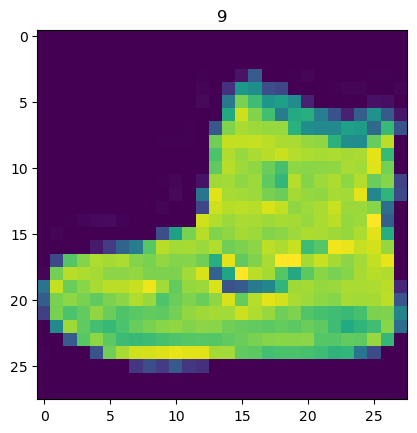

In [6]:
image, label = train_data[0]
print(f'Image shape: {image.shape}')
plt.imshow(image.squeeze())
plt.title(label)

Text(0.5, 1.0, 'Ankle boot')

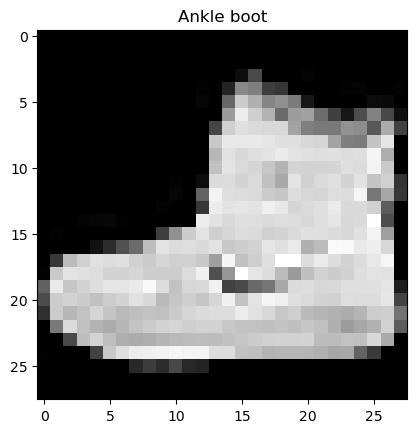

In [7]:
# We can turn images into grayscale using the _cmap_ parameter of plt.imshow()

plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_name[label])

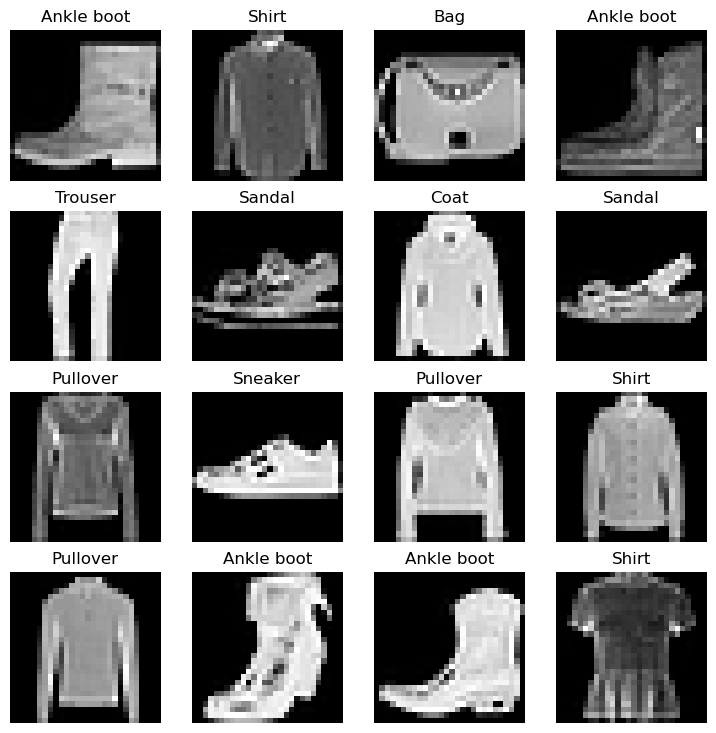

In [8]:
# Plot more images 
torch.manual_seed(42)
fig = plt.figure(figsize = (9,9))
rows,cols = 4,4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows,cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_name[label])
    plt.axis(False)

In [9]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [10]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

# Setup device agnostic-code( for using a GPU if there is one)

In [11]:
# Setup device agnostic code
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

# Builidng the model

`nn.Flatten()` compresses the dimensions of a tensor into a single vector.  `nn.Linear()` layers like their inputs to be in form of feature vectors.

In [12]:
# Create a model with non-linear and linear layers
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [13]:
# Need to setup model with input parameters 
model_1 = FashionMNISTModelV1(input_shape=784, # one for every pixel (28*28)
hidden_units=10, # how many units in the hidden layer
output_shape=len(class_name) # one for every class
  ).to(device) # send model to GPU if available

next(model_1.parameters()).device #check model device

device(type='mps', index=0)

# Setup loss, optimizer and evaluation metrics

In [14]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [17]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),lr = 0.1)

# Functionizing training and testing loops

In [22]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

# Creating a function to time the experiment

In [ ]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [23]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.92895 | Train accuracy: 70.44%
Test loss: 0.54209 | Test accuracy: 80.53%

Epoch: 1
---------
Train loss: 0.49877 | Train accuracy: 82.03%
Test loss: 0.50371 | Test accuracy: 82.17%

Epoch: 2
---------
Train loss: 0.46250 | Train accuracy: 83.21%
Test loss: 0.48537 | Test accuracy: 83.05%

Train time on mps: 25.278 seconds


# Model Evaluation

In [24]:
# Move values to device
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn, 
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 1 results with device-agnostic code 
model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
    device=device
)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.4853745698928833,
 'model_acc': 83.04712460063898}

# Building a CNN

In [25]:
# Create a convolutional neural network 
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, 
    hidden_units=10, 
    output_shape=len(class_name)).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [26]:
# Setup loss and optimizer
loss_FN = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr = 0.1)

In [27]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model 
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.59664 | Train accuracy: 78.39%
Test loss: 0.39092 | Test accuracy: 85.79%

Epoch: 1
---------
Train loss: 0.36324 | Train accuracy: 86.79%
Test loss: 0.36367 | Test accuracy: 86.50%

Epoch: 2
---------
Train loss: 0.32524 | Train accuracy: 88.20%
Test loss: 0.32904 | Test accuracy: 87.98%

Train time on mps: 36.442 seconds


In [28]:
# Get model_2 results 
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3290373384952545,
 'model_acc': 87.97923322683707}

# Comparison between models

In [29]:
import pandas as pd
compare_results = pd.DataFrame([model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV1,0.485375,83.047125
1,FashionMNISTModelV2,0.329037,87.979233


In [30]:
# Add training times to results comparison
compare_results["training_time"] = [total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV1,0.485375,83.047125,25.277903
1,FashionMNISTModelV2,0.329037,87.979233,36.442426


# Visualizing the comparisons

Text(0, 0.5, 'model')

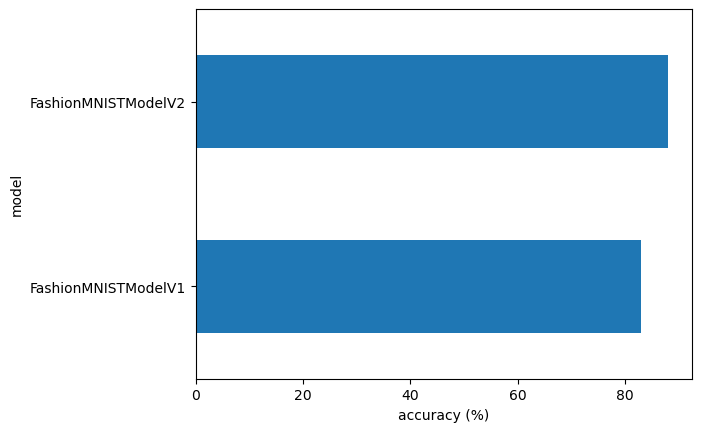

In [32]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

# Make and evaluate random predictions with best model

In [33]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [36]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_name[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [37]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_2, 
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[6.3301e-08, 3.7371e-08, 1.2229e-07, 7.4005e-08, 4.2878e-09, 9.9985e-01,
         3.3410e-08, 2.0018e-05, 2.8601e-05, 1.0152e-04],
        [2.3769e-02, 8.4992e-01, 6.1355e-04, 6.0916e-02, 4.5843e-02, 4.1979e-05,
         1.8684e-02, 1.4159e-04, 4.6861e-05, 1.8541e-05]])

In [38]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

In [39]:
# Are our predictions in the same form as our test labels? 
test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 7, 4, 3, 0, 4, 7, 1]))

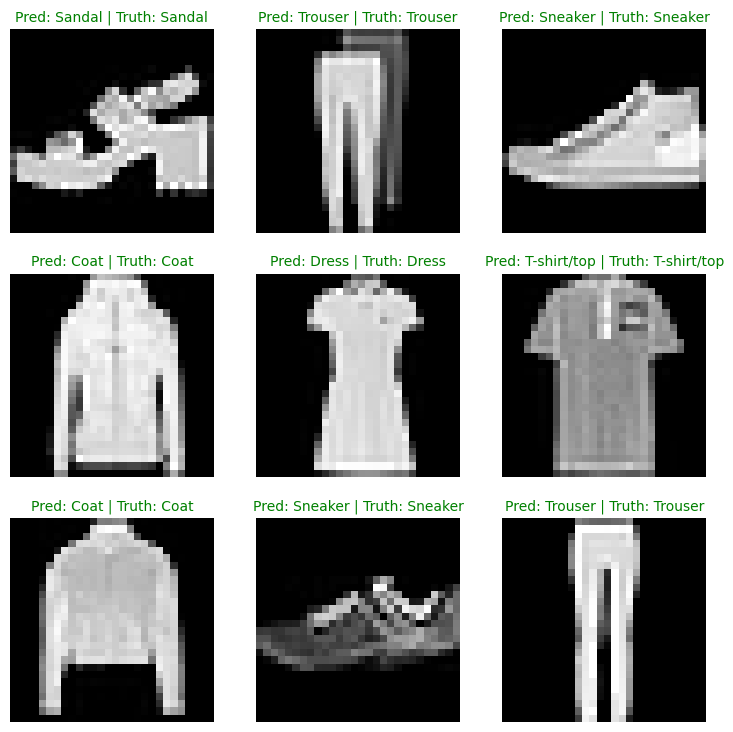

In [42]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_name[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_name[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False)

# Making a Confusion Matrix

In [43]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [45]:
# See if torchmetrics exists, if not, install it
import torchmetrics, mlxtend
print(f"mlxtend version: {mlxtend.__version__}")
assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"

mlxtend version: 0.21.0


`torchmetrics` and `mlxtend` installed, let's make a confusion matrix!

First we'll create a `torchmetrics.ConfusionMatrix` instance telling it how many classes we're dealing with by setting `num_classes=len(class_names)`.

Then we'll create a confusion matrix (in tensor format) by passing our instance our model's predictions (`preds=y_pred_tensor`) and targets (`target=test_data.targets`).

Finally we can plot our confision matrix using the `plot_confusion_matrix()` function from `mlxtend.plotting`.

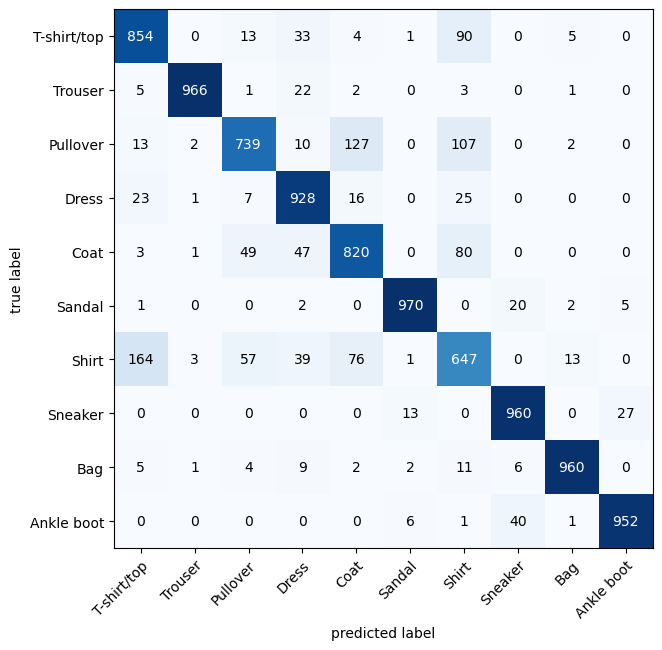

In [46]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_name), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_name, # turn the row and column labels into class names
    figsize=(10, 7)
)

# Save and load the best performing model

Let's finish this section off by saving and loading in our best performing model.

Recall from [notebook 01](https://www.learnpytorch.io/01_pytorch_workflow/#5-saving-and-loading-a-pytorch-model) we can save and load a PyTorch model using a combination of:
* `torch.save` - a function to save a whole PyTorch model or a model's `state_dict()`. 
* `torch.load` - a function to load in a saved PyTorch object.
* `torch.nn.Module.load_state_dict()` - a function to load a saved `state_dict()` into an existing model instance.

You can see more of these three in the [PyTorch saving and loading models documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

For now, let's save our `model_2`'s `state_dict()` then load it back in and evaluate it to make sure the save and load went correctly. 

In [47]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


Now we've got a saved model `state_dict()` we can load it back in using a combination of `load_state_dict()` and `torch.load()`.

Since we're using `load_state_dict()`, we'll need to create a new instance of `FashionMNISTModelV2()` with the same input parameters as our saved model `state_dict()`.

In [49]:
# Create a new instance of FashionMNISTModelV2 (the same class as our saved state_dict())
# Note: loading model will error if the shapes here aren't the same as the saved version
loaded_model_2 = FashionMNISTModelV2(input_shape=1, 
                                    hidden_units=10, # try changing this to 128 and seeing what happens 
                                    output_shape=10) 

# Load in the saved state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_2 = loaded_model_2.to(device)

In [50]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn, 
    accuracy_fn=accuracy_fn
)

loaded_model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3290373384952545,
 'model_acc': 87.97923322683707}

In [51]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3290373384952545,
 'model_acc': 87.97923322683707}

In [52]:
# Check to see if results are close to each other (if they are very far away, there may be an error)
torch.isclose(torch.tensor(model_2_results["model_loss"]), 
              torch.tensor(loaded_model_2_results["model_loss"]),
              atol=1e-08, # absolute tolerance
              rtol=0.0001) # relative tolerance

tensor(True)

## Exercises

All of the exercises are focused on practicing the code in the sections above.

You should be able to complete them by referencing each section or by following the resource(s) linked.

All exercises should be completed using [device-agnostic code](https://pytorch.org/docs/stable/notes/cuda.html#device-agnostic-code).

**Resources:**
* [Exercise template notebook for 03](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/03_pytorch_computer_vision_exercises.ipynb)
* [Example solutions notebook for 03](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/03_pytorch_computer_vision_exercise_solutions.ipynb) (try the exercises *before* looking at this)

1. What are 3 areas in industry where computer vision is currently being used?
2. Search "what is overfitting in machine learning" and write down a sentence about what you find. 
3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each. **Note:** there are lots of these, so don't worry too much about all of them, just pick 3 and start with those.
4. Spend 20-minutes reading and clicking through the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).
    * Upload your own example image using the "upload" button and see what happens in each layer of a CNN as your image passes through it.
5. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.
6. Visualize at least 5 different samples of the MNIST training dataset.
7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.
8. Recreate `model_2` used in this notebook (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.
9. Train the model you built in exercise 8. on CPU and GPU and see how long it takes on each.
10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.
11. Plot a confusion matrix comparing your model's predictions to the truth labels.
12. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?
13. Use a model similar to the trained `model_2` from this notebook to make predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset. 
    * Then plot some predictions where the model was wrong alongside what the label of the image should've been. 
    * After visualing these predictions do you think it's more of a modelling error or a data error? 
    * As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?

## Extra-curriculum
* **Watch:** [MIT's Introduction to Deep Computer Vision](https://www.youtube.com/watch?v=iaSUYvmCekI&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&index=3) lecture. This will give you a great intuition behind convolutional neural networks.
* Spend 10-minutes clicking thorugh the different options of the [PyTorch vision library](https://pytorch.org/vision/stable/index.html), what different modules are available?
* Lookup "most common convolutional neural networks", what architectures do you find? Are any of them contained within the [`torchvision.models`](https://pytorch.org/vision/stable/models.html) library? What do you think you could do with these?
* For a large number of pretrained PyTorch computer vision models as well as many different extensions to PyTorch's computer vision functionalities check out the [PyTorch Image Models library `timm`](https://github.com/rwightman/pytorch-image-models/) (Torch Image Models) by Ross Wightman.